# VDEH Enrichment Konflikt-Analyse

**Fokus:** Analyse der Konflikte zwischen VDEH-Daten und DNB-Anreicherung

## 🎯 Ziel
- Detaillierte Analyse der erkannten Konflikte
- Unterscheidung zwischen auflösbaren und nicht-auflösbaren Konflikten
- Mustersuche in Konflikt-Typen
- Visualisierung der Konflikt-Verteilung

## 📚 Input
- **Checkpoint**: `data/vdeh/processed/enrichment_checkpoint.parquet` (aus Enrichment-Pipeline)

## 📊 Analysierte Konflikt-Typen
- **Titel**: Unterschiede zwischen VDEH und DNB Titel
- **Autoren**: Unterschiede in Autorenlisten
- **Jahr**: Unterschiedliche Jahresangaben
- **Verlag**: Unterschiedliche Verlagsangaben

In [1]:
# 🛠️ SETUP UND DATEN LADEN
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings

# Projektroot finden
current_dir = Path.cwd()
project_root = None

for parent in [current_dir] + list(current_dir.parents):
    if (parent / 'config.yaml').exists():
        project_root = parent
        break

if project_root is None:
    raise FileNotFoundError("config.yaml nicht gefunden!")

# Config laden
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from config_loader import load_config
config = load_config(project_root / 'config.yaml')

# Matplotlib konfigurieren
plt.rcParams['figure.figsize'] = config.get('visualization.matplotlib.figure_size', [12, 8])
plt.rcParams['figure.dpi'] = config.get('visualization.matplotlib.dpi', 100)

if not config.get('debug.verbose_output', True):
    warnings.filterwarnings('ignore')

print(f"📁 Projektroot: {project_root}")
print("✅ Konfiguration geladen")

✅ Konfiguration geladen: /media/sz/Data/Bibo/analysis/config.yaml
📁 Projektroot: /media/sz/Data/Bibo/analysis
✅ Konfiguration geladen


In [2]:
# 📂 ENRICHMENT CHECKPOINT LADEN
processed_dir = config.project_root / config.get('paths.data.vdeh.processed')
checkpoint_path = processed_dir / 'enrichment_checkpoint.parquet'

if not checkpoint_path.exists():
    raise FileNotFoundError(f"Checkpoint-Datei nicht gefunden: {checkpoint_path}\n"
                          "Bitte führen Sie zuerst 04_vdeh_data_enrichment.ipynb aus.")

# Checkpoint laden
enrichment_df = pd.read_parquet(checkpoint_path)

print(f"📂 Enrichment-Daten geladen aus: {checkpoint_path}")
print(f"📊 Gesamt Records: {len(enrichment_df):,}")
print(f"📋 Spalten: {list(enrichment_df.columns)}")
print(f"💾 Memory: {enrichment_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Basis-Statistiken
print(f"\n📊 Enrichment-Übersicht:")
if 'dnb_found' in enrichment_df.columns:
    dnb_found_count = (enrichment_df['dnb_found'] == True).sum()
    print(f"   DNB-Treffer: {dnb_found_count:,} ({dnb_found_count/len(enrichment_df)*100:.1f}%)")

if 'has_conflict' in enrichment_df.columns:
    conflicts_count = (enrichment_df['has_conflict'] == True).sum()
    print(f"   Konflikte: {conflicts_count:,} ({conflicts_count/len(enrichment_df)*100:.1f}%)")

📂 Enrichment-Daten geladen aus: /media/sz/Data/Bibo/analysis/data/vdeh/processed/enrichment_checkpoint.parquet
📊 Gesamt Records: 27,155
📋 Spalten: ['id', 'title', 'authors', 'year', 'publisher', 'isbn', 'issn', 'authors_str', 'num_authors', 'isbn_valid', 'isbn_status', 'issn_valid', 'issn_status', 'lang_code', 'lang_confidence', 'lang_name', 'completeness_score', 'quality_category', 'dnb_title', 'dnb_authors', 'dnb_year', 'dnb_publisher', 'dnb_found', 'has_conflict', 'conflict_details', 'query_method']
💾 Memory: 22.9 MB

📊 Enrichment-Übersicht:
   DNB-Treffer: 2,812 (10.4%)
   Konflikte: 2,582 (9.5%)


In [3]:
# 🔍 KONFLIKT-DATEN EXTRAHIEREN
print("🔍 === KONFLIKT-EXTRAKTION ===\n")

# Filtere nur Records mit Konflikten
conflicts_df = enrichment_df[enrichment_df['has_conflict'] == True].copy()

print(f"⚠️  Gefundene Konflikte: {len(conflicts_df):,}")

if len(conflicts_df) > 0:
    # Relevante Spalten für Analyse
    conflict_columns = [
        'id',
        'isbn',
        'issn',
        # Original-Daten
        'title',
        'authors_str',
        'year',
        'publisher',
        # DNB-Daten
        'dnb_title',
        'dnb_authors',
        'dnb_year',
        'dnb_publisher',
        # Konflikt-Info
        'conflict_details',
        'conflict_resolvable',
        'query_method'
    ]
    
    # Nur vorhandene Spalten auswählen
    available_columns = [col for col in conflict_columns if col in conflicts_df.columns]
    conflicts_df = conflicts_df[available_columns]
    
    print(f"📋 Spalten im Konflikt-DataFrame: {len(available_columns)}")
    print(f"   {', '.join(available_columns)}")
else:
    print("✅ Keine Konflikte gefunden - Alle DNB-Daten stimmen überein!")

🔍 === KONFLIKT-EXTRAKTION ===

⚠️  Gefundene Konflikte: 2,582
📋 Spalten im Konflikt-DataFrame: 13
   id, isbn, issn, title, authors_str, year, publisher, dnb_title, dnb_authors, dnb_year, dnb_publisher, conflict_details, query_method


In [ ]:
# 📊 IDENTISCHE EINTRÄGE ANALYSE
print("📊 === IDENTISCHE EINTRÄGE (DNB-TREFFER OHNE KONFLIKTE) ===\n")

# DNB-Treffer ohne Konflikte = Identische Einträge
if 'dnb_found' in enrichment_df.columns and 'has_conflict' in enrichment_df.columns:
    # Datensätze mit DNB-Treffer
    dnb_found = (enrichment_df['dnb_found'] == True)
    dnb_found_count = dnb_found.sum()
    
    # Davon: OHNE Konflikt = Identisch
    identical_entries = dnb_found & (enrichment_df['has_conflict'] == False)
    identical_count = identical_entries.sum()
    
    # Mit Konflikt
    with_conflicts = dnb_found & (enrichment_df['has_conflict'] == True)
    conflicts_count = with_conflicts.sum()
    
    print(f"🔍 DNB-Treffer gesamt: {dnb_found_count:,}")
    print(f"\n✅ Identische Einträge (OHNE Konflikt): {identical_count:,} ({identical_count/dnb_found_count*100:.1f}% der Treffer)")
    print(f"⚠️  Mit Konflikten:                      {conflicts_count:,} ({conflicts_count/dnb_found_count*100:.1f}% der Treffer)")
    
    # Zusätzliche Statistik: Identische nach Query-Methode
    if 'query_method' in enrichment_df.columns:
        print(f"\n📋 Identische Einträge nach Query-Methode:")
        
        identical_df = enrichment_df[identical_entries]
        query_methods = identical_df['query_method'].value_counts()
        
        for method, count in query_methods.items():
            pct = count / identical_count * 100
            bar = '█' * int(pct / 5)
            print(f"   {method:20} {count:5,} ({pct:5.1f}%) {bar}")
    
    # Von den gesamten Records
    total_records = len(enrichment_df)
    print(f"\n📊 Von allen {total_records:,} verarbeiteten Records:")
    print(f"   ✅ Identisch mit DNB:  {identical_count:,} ({identical_count/total_records*100:.1f}%)")
    print(f"   ⚠️  Mit Konflikten:     {conflicts_count:,} ({conflicts_count/total_records*100:.1f}%)")
    print(f"   ❌ Nicht in DNB:       {(total_records - dnb_found_count):,} ({(total_records - dnb_found_count)/total_records*100:.1f}%)")
    
    # Erstelle DataFrame mit identischen Einträgen (für weitere Analyse)
    identical_records_df = enrichment_df[identical_entries].copy()
    print(f"\n💾 DataFrame 'identical_records_df' erstellt mit {len(identical_records_df):,} Records")
    
else:
    print("⚠️  Spalten 'dnb_found' oder 'has_conflict' nicht gefunden")

In [9]:
# 📊 KONFLIKT-TYPEN ANALYSE
if len(conflicts_df) > 0:
    print("📊 === KONFLIKT-TYPEN ANALYSE ===\n")
    
    # 1. Konflikt-Typen Verteilung
    print("📋 Konflikt-Typen (Einzeln):")
    conflict_types = conflicts_df['conflict_details'].str.split(', ').explode().value_counts()
    
    for conflict_type, count in conflict_types.items():
        pct = count / len(conflicts_df) * 100
        bar = '█' * int(pct / 2)
        print(f"   {conflict_type:12} {count:5,} ({pct:5.1f}%) {bar}")
    
    # 2. Konflikt-Kombinationen
    print(f"\n📋 Konflikt-Kombinationen (Top 10):")
    conflict_combos = conflicts_df['conflict_details'].value_counts().head(10)
    
    for combo, count in conflict_combos.items():
        pct = count / len(conflicts_df) * 100
        print(f"   {combo:30} {count:5,} ({pct:5.1f}%)")
    
    # 3. Auflösbare vs. Nicht-Auflösbare Konflikte
    if 'conflict_resolvable' in conflicts_df.columns:
        print(f"\n✨ Auflösbarkeits-Analyse:")
        
        has_resolvable = conflicts_df['conflict_resolvable'].notna()
        num_resolvable = has_resolvable.sum()
        num_not_resolvable = (~has_resolvable).sum()
        
        print(f"   Auflösbar (Substring):     {num_resolvable:5,} ({num_resolvable/len(conflicts_df)*100:.1f}%)")
        print(f"   Nicht auflösbar:           {num_not_resolvable:5,} ({num_not_resolvable/len(conflicts_df)*100:.1f}%)")
        
        if num_resolvable > 0:
            print(f"\n   Auflösbare Konflikt-Typen:")
            resolvable_types = conflicts_df[has_resolvable]['conflict_resolvable'].str.split(', ').explode().value_counts()
            
            for conflict_type, count in resolvable_types.items():
                pct_of_resolvable = count / num_resolvable * 100
                print(f"      {conflict_type:12} {count:5,} ({pct_of_resolvable:5.1f}% der auflösbaren)")
    
    # 4. Query-Methode bei Konflikten
    if 'query_method' in conflicts_df.columns:
        print(f"\n🔍 Konflikte nach Query-Methode:")
        query_method_dist = conflicts_df['query_method'].value_counts()
        
        for method, count in query_method_dist.items():
            pct = count / len(conflicts_df) * 100
            print(f"   {method:20} {count:5,} ({pct:5.1f}%)")

📊 === KONFLIKT-TYPEN ANALYSE ===

📋 Konflikt-Typen (Einzeln):
   title        2,391 ( 92.6%) ██████████████████████████████████████████████
   authors      1,171 ( 45.4%) ██████████████████████
   year           220 (  8.5%) ████

📋 Konflikt-Kombinationen (Top 10):
   title                          1,314 ( 50.9%)
   title, authors                   890 ( 34.5%)
   authors                          158 (  6.1%)
   title, authors, year             103 (  4.0%)
   title, year                       84 (  3.3%)
   authors, year                     20 (  0.8%)
   year                              13 (  0.5%)

🔍 Konflikte nach Query-Methode:
   ISBN                 2,582 (100.0%)


📊 === KONFLIKT-VISUALISIERUNGEN ===

💾 Visualisierung gespeichert: /media/sz/Data/Bibo/analysis/data/vdeh/exports/vdeh_enrichment_conflicts_analysis.png


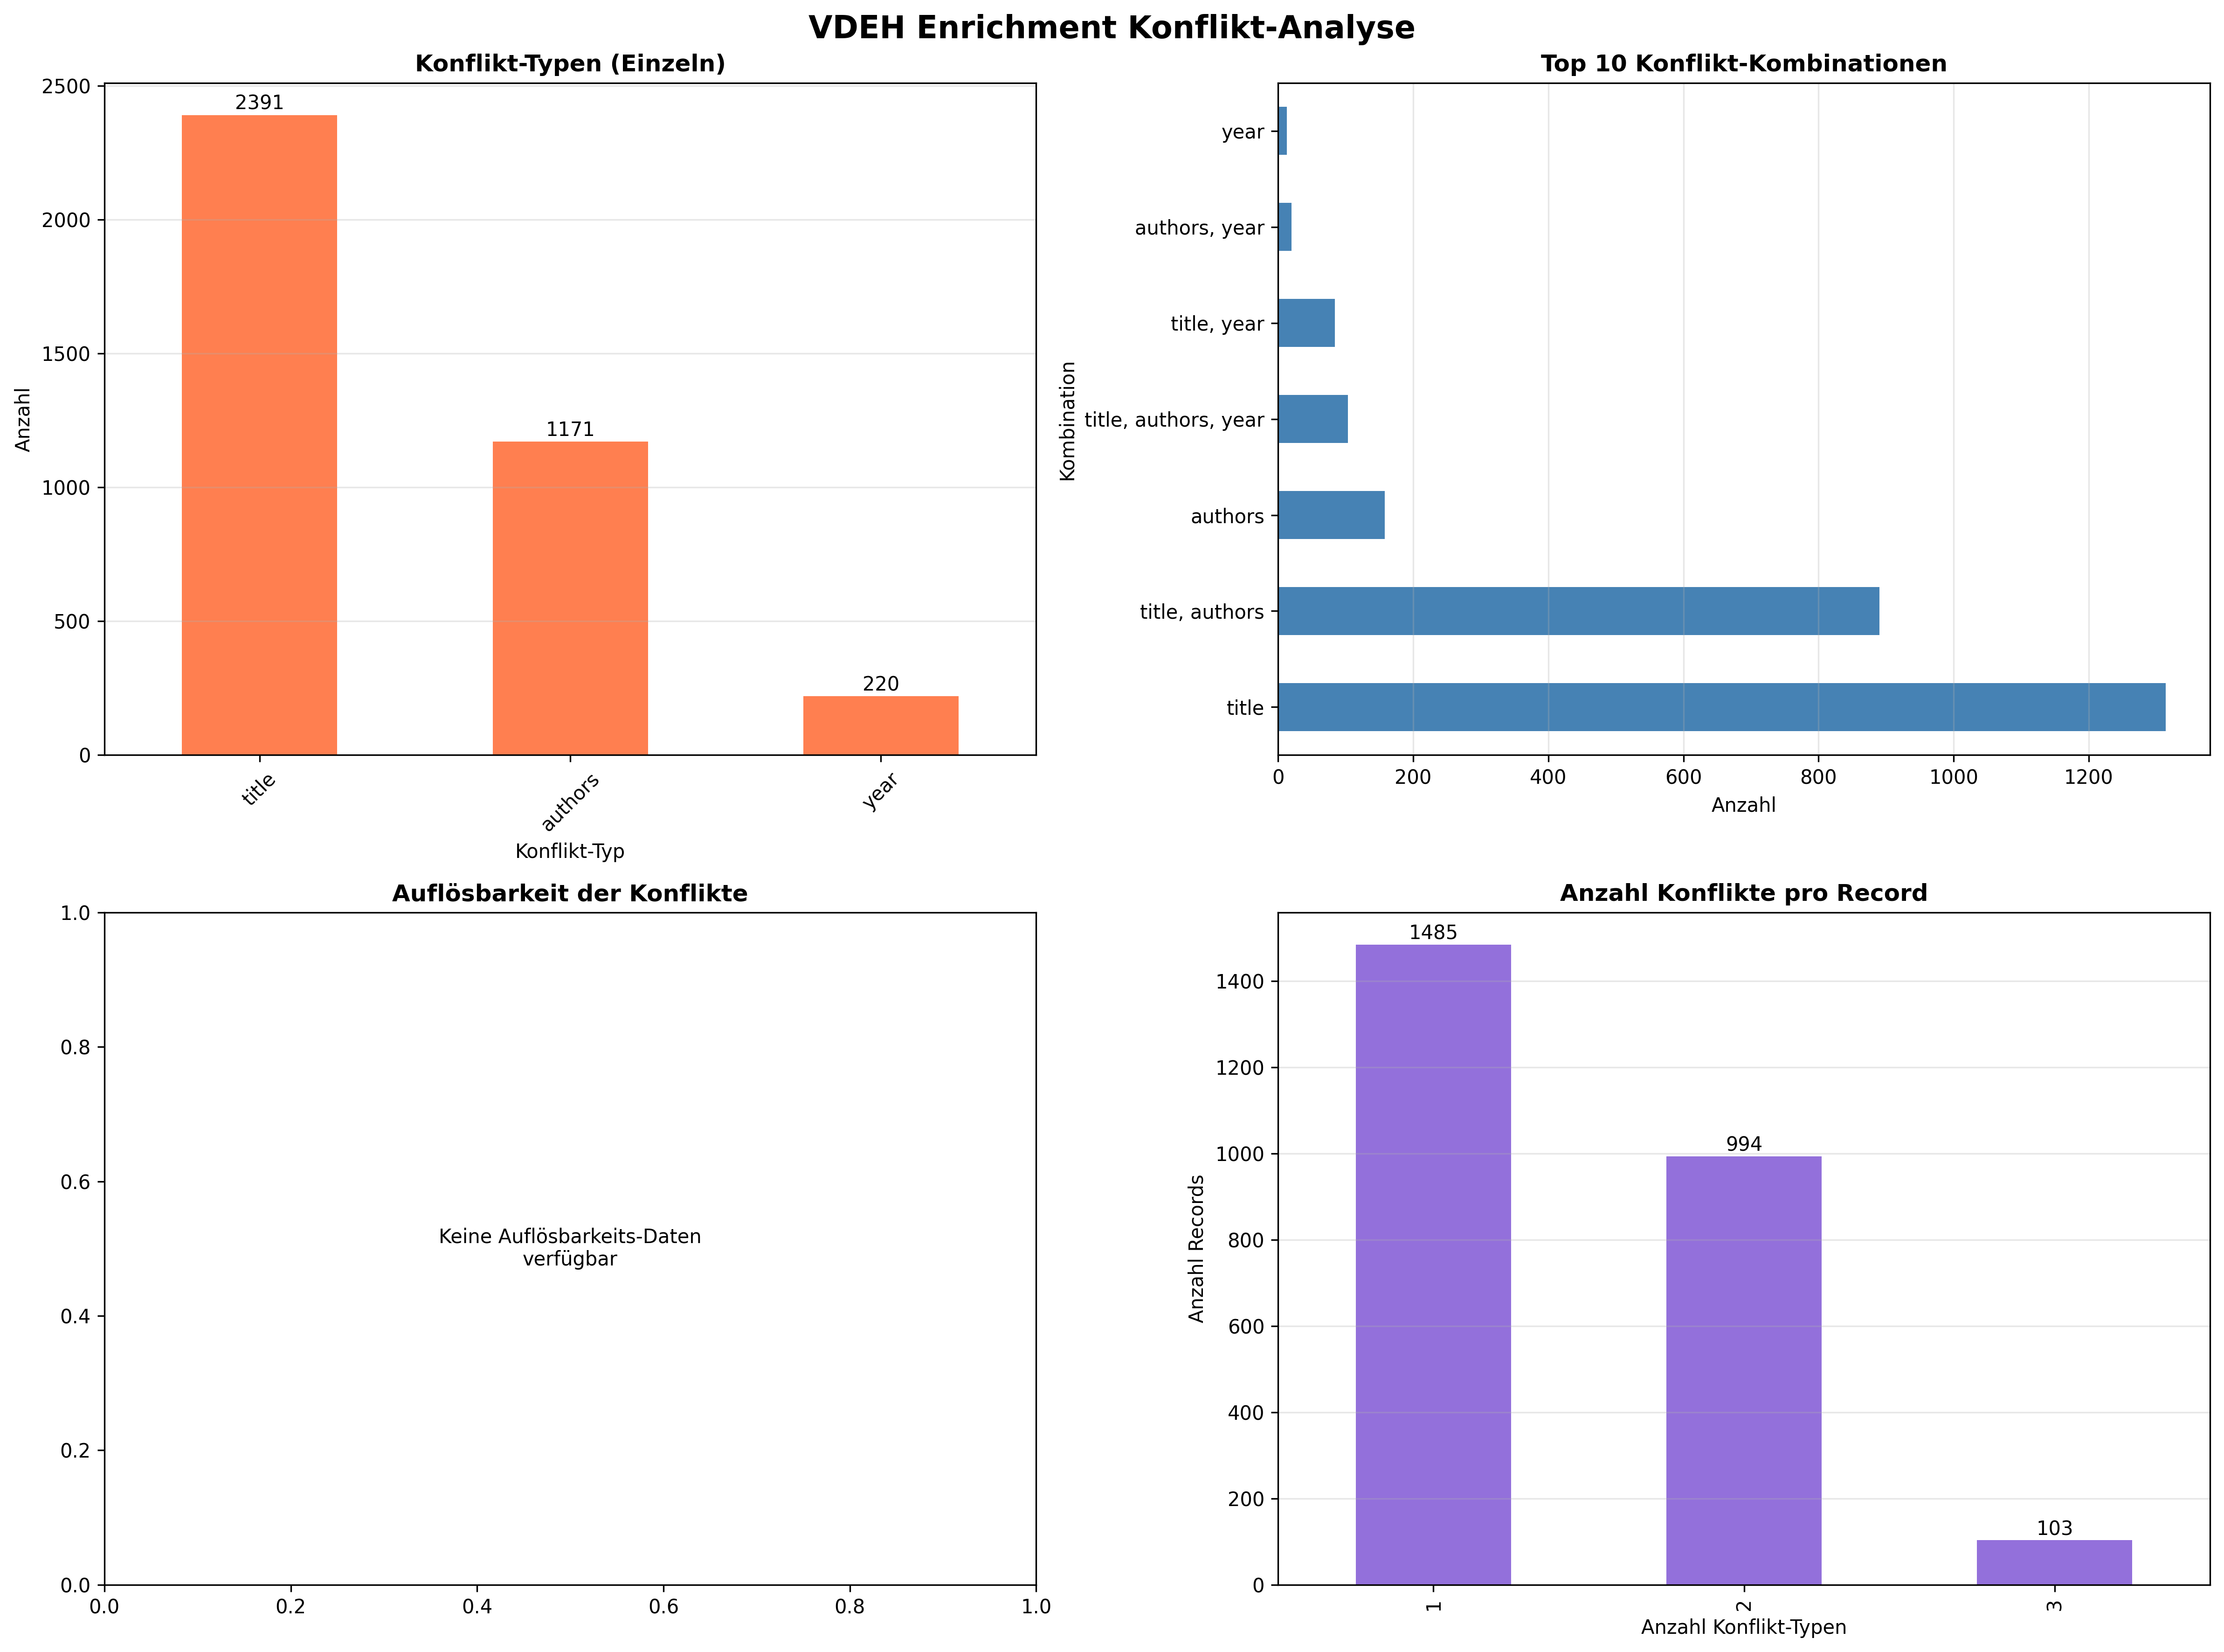

In [5]:
# 📊 VISUALISIERUNGEN
if len(conflicts_df) > 0:
    print("📊 === KONFLIKT-VISUALISIERUNGEN ===\n")
    
    # Erstelle Figure mit Subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('VDEH Enrichment Konflikt-Analyse', fontsize=16, fontweight='bold')
    
    # 1. Konflikt-Typen Verteilung (Bar)
    ax1 = axes[0, 0]
    conflict_types = conflicts_df['conflict_details'].str.split(', ').explode().value_counts()
    conflict_types.plot(kind='bar', ax=ax1, color='coral')
    ax1.set_title('Konflikt-Typen (Einzeln)', fontweight='bold')
    ax1.set_xlabel('Konflikt-Typ')
    ax1.set_ylabel('Anzahl')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Werte auf Balken
    for i, v in enumerate(conflict_types.values):
        ax1.text(i, v + 5, str(v), ha='center', va='bottom')
    
    # 2. Top 10 Konflikt-Kombinationen (Horizontal Bar)
    ax2 = axes[0, 1]
    conflict_combos = conflicts_df['conflict_details'].value_counts().head(10)
    conflict_combos.plot(kind='barh', ax=ax2, color='steelblue')
    ax2.set_title('Top 10 Konflikt-Kombinationen', fontweight='bold')
    ax2.set_xlabel('Anzahl')
    ax2.set_ylabel('Kombination')
    ax2.grid(axis='x', alpha=0.3)
    
    # 3. Auflösbar vs. Nicht-Auflösbar (Pie)
    ax3 = axes[1, 0]
    if 'conflict_resolvable' in conflicts_df.columns:
        has_resolvable = conflicts_df['conflict_resolvable'].notna()
        resolvable_counts = [has_resolvable.sum(), (~has_resolvable).sum()]
        labels = ['Auflösbar\n(Substring)', 'Nicht auflösbar']
        colors = ['lightgreen', 'lightcoral']
        
        ax3.pie(resolvable_counts, labels=labels, autopct='%1.1f%%', 
                colors=colors, startangle=90, textprops={'fontsize': 10})
        ax3.set_title('Auflösbarkeit der Konflikte', fontweight='bold')
    else:
        ax3.text(0.5, 0.5, 'Keine Auflösbarkeits-Daten\nverfügbar', 
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Auflösbarkeit der Konflikte', fontweight='bold')
    
    # 4. Anzahl Konflikte pro Record (Histogram)
    ax4 = axes[1, 1]
    conflicts_per_record = conflicts_df['conflict_details'].str.split(', ').str.len()
    conflicts_per_record.value_counts().sort_index().plot(kind='bar', ax=ax4, color='mediumpurple')
    ax4.set_title('Anzahl Konflikte pro Record', fontweight='bold')
    ax4.set_xlabel('Anzahl Konflikt-Typen')
    ax4.set_ylabel('Anzahl Records')
    ax4.grid(axis='y', alpha=0.3)
    
    # Werte auf Balken
    for i, (idx, v) in enumerate(conflicts_per_record.value_counts().sort_index().items()):
        ax4.text(i, v + 2, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    
    # Speichern
    exports_dir = config.project_root / config.get('paths.data.vdeh.exports')
    exports_dir.mkdir(parents=True, exist_ok=True)
    output_path = exports_dir / 'vdeh_enrichment_conflicts_analysis.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"💾 Visualisierung gespeichert: {output_path}")
    
    plt.show()
else:
    print("✅ Keine Konflikte für Visualisierung vorhanden")

In [6]:
# 🔍 BEISPIEL-KONFLIKTE ANZEIGEN
if len(conflicts_df) > 0:
    print("🔍 === BEISPIEL-KONFLIKTE ===\n")
    
    # Gruppiere nach Konflikt-Typ und zeige Beispiele
    unique_conflict_types = conflicts_df['conflict_details'].unique()
    
    for conflict_type in unique_conflict_types[:5]:  # Nur erste 5 Typen
        print(f"\n{'='*80}")
        print(f"📋 Konflikt-Typ: {conflict_type}")
        print(f"{'='*80}")
        
        # Finde Beispiele für diesen Konflikt-Typ
        examples = conflicts_df[conflicts_df['conflict_details'] == conflict_type].head(2)
        
        for idx, row in examples.iterrows():
            print(f"\n📌 Record: {row['id'][:60]}...")
            
            if 'isbn' in row and pd.notna(row['isbn']):
                print(f"   ISBN: {row['isbn']}")
            
            if 'conflict_resolvable' in row and pd.notna(row['conflict_resolvable']):
                print(f"   ✨ Auflösbar: {row['conflict_resolvable']}")
            else:
                print(f"   ❌ Nicht auflösbar")
            
            # Zeige Details für jeden Konflikt-Teil
            conflict_parts = conflict_type.split(', ')
            
            for part in conflict_parts:
                print(f"\n   📊 {part.upper()}-Konflikt:")
                
                if part == 'title':
                    print(f"      Original: {row['title'][:100]}..." if len(str(row['title'])) > 100 else f"      Original: {row['title']}")
                    print(f"      DNB:      {row['dnb_title'][:100]}..." if len(str(row['dnb_title'])) > 100 else f"      DNB:      {row['dnb_title']}")
                
                elif part == 'authors':
                    print(f"      Original: {row['authors_str'][:80]}..." if len(str(row['authors_str'])) > 80 else f"      Original: {row['authors_str']}")
                    print(f"      DNB:      {row['dnb_authors'][:80]}..." if len(str(row['dnb_authors'])) > 80 else f"      DNB:      {row['dnb_authors']}")
                
                elif part == 'year':
                    print(f"      Original: {row['year']}")
                    print(f"      DNB:      {row['dnb_year']}")
                
                elif part == 'publisher':
                    print(f"      Original: {row['publisher'][:80]}..." if len(str(row['publisher'])) > 80 else f"      Original: {row['publisher']}")
                    print(f"      DNB:      {row['dnb_publisher'][:80]}..." if len(str(row['dnb_publisher'])) > 80 else f"      DNB:      {row['dnb_publisher']}")
    
    print(f"\n{'='*80}")
    print(f"💡 Hinweis: Es wurden maximal 5 verschiedene Konflikt-Typen mit je 2 Beispielen gezeigt")
    print(f"   Gesamt verfügbare Konflikte: {len(conflicts_df):,}")
else:
    print("✅ Keine Konflikte zum Anzeigen vorhanden")

🔍 === BEISPIEL-KONFLIKTE ===


📋 Konflikt-Typ: title

📌 Record: aleph-publish:000000023...
   ISBN: 3-428-05409-1
   ❌ Nicht auflösbar

   📊 TITLE-Konflikt:
      Original: ¬Die¬ deutsche Roheisenindustrie 1871-1913. Eine quantitativ-historische Untersuchung
      DNB:      Die deutsche Roheisenindustrie 1871 - 1913

📌 Record: aleph-publish:000000039...
   ISBN: 3-802-74302-4
   ❌ Nicht auflösbar

   📊 TITLE-Konflikt:
      Original: Brandschutz und Feuersicherheit in Arbeitsstätten
      DNB:      Brandschutz und Feuersicherheit in Arbeitsstätten

📋 Konflikt-Typ: title, authors

📌 Record: aleph-publish:000000038...
   ISBN: 3-527-26070-6
   ❌ Nicht auflösbar

   📊 TITLE-Konflikt:
      Original: Korrosionskunde im Experiment. Untersuchungsverfahren, Messtechnik, Aussagen. Erweiterte Fassung ein...
      DNB:      Korrosionskunde im Experiment

   📊 AUTHORS-Konflikt:
      Original: Heitz, E. | Henkhaus, R. | Rahmel, A. | DECHEMA
      DNB:      Heitz, Ewald, Henkhaus, Rolf, Rahmel,

In [7]:
# 💾 KONFLIKT-DATEN EXPORTIEREN
if len(conflicts_df) > 0:
    print("💾 === KONFLIKT-DATEN EXPORT ===\n")
    
    exports_dir = config.project_root / config.get('paths.data.vdeh.exports')
    exports_dir.mkdir(parents=True, exist_ok=True)
    
    # 1. CSV Export (für manuelle Überprüfung)
    csv_path = exports_dir / 'vdeh_enrichment_conflicts.csv'
    conflicts_df.to_csv(csv_path, index=False, encoding='utf-8-sig')
    print(f"📄 CSV exportiert: {csv_path}")
    print(f"   Records: {len(conflicts_df):,}")
    print(f"   Dateigröße: {csv_path.stat().st_size / 1024:.1f} KB")
    
    # 2. Zusammenfassungs-Report
    report_path = exports_dir / 'vdeh_enrichment_conflicts_summary.txt'
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("VDEH ENRICHMENT KONFLIKT-ANALYSE - ZUSAMMENFASSUNG\n")
        f.write("="*80 + "\n\n")
        
        f.write(f"Gesamt Konflikte: {len(conflicts_df):,}\n\n")
        
        # Konflikt-Typen
        f.write("KONFLIKT-TYPEN (Einzeln):\n")
        f.write("-"*40 + "\n")
        conflict_types = conflicts_df['conflict_details'].str.split(', ').explode().value_counts()
        for conflict_type, count in conflict_types.items():
            pct = count / len(conflicts_df) * 100
            f.write(f"  {conflict_type:12} {count:5,} ({pct:5.1f}%)\n")
        
        # Top Kombinationen
        f.write("\nTOP 10 KONFLIKT-KOMBINATIONEN:\n")
        f.write("-"*40 + "\n")
        conflict_combos = conflicts_df['conflict_details'].value_counts().head(10)
        for combo, count in conflict_combos.items():
            pct = count / len(conflicts_df) * 100
            f.write(f"  {combo:30} {count:5,} ({pct:5.1f}%)\n")
        
        # Auflösbarkeit
        if 'conflict_resolvable' in conflicts_df.columns:
            f.write("\nAUFLÖSBARKEIT:\n")
            f.write("-"*40 + "\n")
            has_resolvable = conflicts_df['conflict_resolvable'].notna()
            num_resolvable = has_resolvable.sum()
            num_not_resolvable = (~has_resolvable).sum()
            
            f.write(f"  Auflösbar (Substring):  {num_resolvable:5,} ({num_resolvable/len(conflicts_df)*100:.1f}%)\n")
            f.write(f"  Nicht auflösbar:        {num_not_resolvable:5,} ({num_not_resolvable/len(conflicts_df)*100:.1f}%)\n")
    
    print(f"\n📄 Zusammenfassung exportiert: {report_path}")
    print(f"   Dateigröße: {report_path.stat().st_size / 1024:.1f} KB")
    
    print(f"\n✅ Export abgeschlossen")
else:
    print("ℹ️  Keine Konflikte zum Exportieren vorhanden")

💾 === KONFLIKT-DATEN EXPORT ===

📄 CSV exportiert: /media/sz/Data/Bibo/analysis/data/vdeh/exports/vdeh_enrichment_conflicts.csv
   Records: 2,582
   Dateigröße: 786.4 KB

📄 Zusammenfassung exportiert: /media/sz/Data/Bibo/analysis/data/vdeh/exports/vdeh_enrichment_conflicts_summary.txt
   Dateigröße: 0.8 KB

✅ Export abgeschlossen


In [8]:
# 📊 STATISTISCHE ZUSAMMENFASSUNG
if len(conflicts_df) > 0:
    print("📊 === STATISTISCHE ZUSAMMENFASSUNG ===\n")
    
    # Anzahl Konflikte pro Record
    conflicts_per_record = conflicts_df['conflict_details'].str.split(', ').str.len()
    
    print("Konflikte pro Record:")
    print(f"   Minimum:     {conflicts_per_record.min()}")
    print(f"   Maximum:     {conflicts_per_record.max()}")
    print(f"   Durchschnitt: {conflicts_per_record.mean():.2f}")
    print(f"   Median:      {conflicts_per_record.median():.0f}")
    
    print(f"\nVerteilung:")
    for num_conflicts in sorted(conflicts_per_record.unique()):
        count = (conflicts_per_record == num_conflicts).sum()
        pct = count / len(conflicts_df) * 100
        bar = '█' * int(pct / 2)
        print(f"   {num_conflicts} Konflikt(e): {count:5,} ({pct:5.1f}%) {bar}")
    
    # Auflösbarkeits-Rate pro Konflikt-Typ
    if 'conflict_resolvable' in conflicts_df.columns:
        print(f"\n✨ Auflösbarkeits-Rate pro Konflikt-Typ:")
        
        for conflict_type in ['title', 'authors', 'year', 'publisher']:
            # Alle mit diesem Konflikt-Typ
            has_conflict = conflicts_df['conflict_details'].str.contains(conflict_type, na=False)
            total_with_conflict = has_conflict.sum()
            
            if total_with_conflict > 0:
                # Davon auflösbar
                is_resolvable = conflicts_df['conflict_resolvable'].str.contains(conflict_type, na=False)
                resolvable_count = (has_conflict & is_resolvable).sum()
                resolvable_rate = resolvable_count / total_with_conflict * 100
                
                print(f"   {conflict_type:12} {resolvable_count:5,}/{total_with_conflict:5,} ({resolvable_rate:5.1f}%)")
    
    print(f"\n{'='*80}")
    print(f"✅ Konflikt-Analyse abgeschlossen")
    print(f"   Verfügbar als: conflicts_df DataFrame")
    print(f"   Shape: {conflicts_df.shape}")
else:
    print("✅ Keine Konflikte gefunden - Perfekte Übereinstimmung mit DNB-Daten!")

📊 === STATISTISCHE ZUSAMMENFASSUNG ===

Konflikte pro Record:
   Minimum:     1
   Maximum:     3
   Durchschnitt: 1.46
   Median:      1

Verteilung:
   1 Konflikt(e): 1,485 ( 57.5%) ████████████████████████████
   2 Konflikt(e):   994 ( 38.5%) ███████████████████
   3 Konflikt(e):   103 (  4.0%) █

✅ Konflikt-Analyse abgeschlossen
   Verfügbar als: conflicts_df DataFrame
   Shape: (2582, 13)
